In [1]:
import sys, os
PROJECT_ROOT = "../../../../.."
if os.path.abspath(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, os.path.abspath(PROJECT_ROOT))

In [2]:
# !pip install -e /mnt/user-home/git/coba
# !pip install vowpalwabbit

In [3]:
import itertools as it
import coba as cb
import matplotlib.pyplot as plt

---

## Evaluating Exploration From Logged

Our goal is to use logged data to estimate online exploration performance.

To do this we have three options:
  1. Perform on-policy evaluation using a reward estimator
  2. Perform off-policy evaluation using the logged data
  3. Use rejection sampling to make the logged data look like the desired exploration
  
We will evaluate all three options using logged data that we generate from a large set of classification datasets. By conducting this experiment over many datasets we can get a sense of the expected performance for each method independent of any one dataset. We will also intentionally use a misguided logging policy to generate our data to ensure that the logging policy doesn't look anything like the policies we wish to estimate.  

#### 1. Create evaluation data
To create our logged data we use a `MisguidedLearner`. This learner behaves very differently from the policies we want to evaluate.

In [4]:
envs2 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=100_000,strict=True).chunk()
logs2 = envs2.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(),1,-1)).ope_rewards("DR").cache()

#### 2. Define the experiment 

In [5]:
ground_truth  = it.product(envs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
first_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
second_option = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OffPolicyEvaluator()])
third_option  = it.product(logs2,[cb.VowpalEpsilonLearner(epsilon=0.05)],[cb.ExplorationEvaluator()])
ee_epsilon_50 = it.product(logs2,[cb.VowpalEpsilonLearner(epsilon=0.2)],[cb.ExplorationEvaluator()])

experiment2 = cb.Experiment(it.chain(ground_truth,first_option,second_option,third_option, ee_epsilon_50))

#### 3. Run the experiment

In [6]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
from datetime import datetime
file_name = f'{datetime.now()}.log'
experiment2.run(file_name,processes=30,quiet=True)

CPU times: user 2min 3s, sys: 11.4 s, total: 2min 14s
Wall time: 25min 38s
{'Learners': 5, 'Environments': 416, 'Interactions': 29504436}


#### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [7]:
result2 = cb.Result.from_save(file_name)

In [8]:
df = result2.interactions.to_pandas()
df

,environment_id,learner_id,evaluator_id,index,reward
0,20,0,0,1,1.00000
1,20,0,0,2,1.00000
2,20,0,0,3,1.00000
3,20,0,0,4,1.00000
4,20,0,0,5,1.00000
...,...,...,...,...,...
29504431,409,4,4,2759,0.48276
29504432,409,4,4,2760,0.79495
29504433,409,4,4,2761,0.86051
29504434,409,4,4,2762,0.85568


In [9]:
result2.learners.to_pandas()

,learner_id,args,family
0,0,--cb_explore_adf --epsilon 0.05 --random_seed ...,vw
1,1,--cb_explore_adf --epsilon 0.05 --random_seed ...,vw
2,2,--cb_explore_adf --epsilon 0.05 --random_seed ...,vw
3,3,--cb_explore_adf --epsilon 0.05 --random_seed ...,vw
4,4,--cb_explore_adf --epsilon 0.2 --random_seed 1...,vw


In [10]:
df.groupby(['learner_id']).environment_id.nunique()

learner_id
0    97
1    97
2    97
3    97
4    97
Name: environment_id, dtype: int64

We removed 41 learner evaluations because they were shorter than 1000 interactions.
We shortened 443 environments because they were longer than the shortest environment.
We removed 25 openml_task because they did not exist for every ['ope_reward', 'eval_type', 'learner_id'].


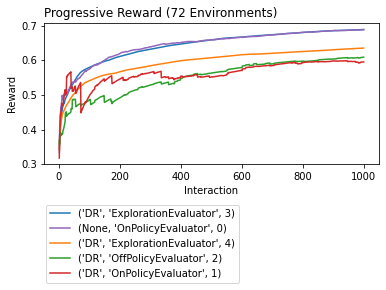

In [11]:
# Comparison of different policies
result2.filter_fin(1000).plot_learners(l=['ope_reward','eval_type', 'learner_id'],p='openml_task')

We removed 91 learner evaluations because they were shorter than 2000 interactions.
We shortened 394 environments because they were longer than the shortest environment.
We removed 48 openml_task because they did not exist for every ['ope_reward', 'eval_type', 'learner_id'].


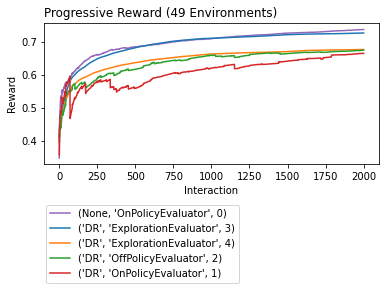

In [12]:
# On more data
result2.filter_fin(2000).plot_learners(l=['ope_reward','eval_type', 'learner_id'],p='openml_task')

We shortened 193 environments because they were longer than the shortest environment.


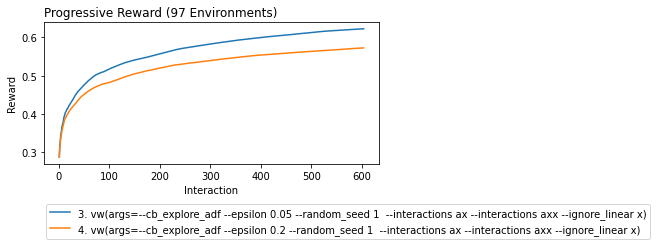

In [13]:
# Contrasting the two exploration policies
result2.filter_val(eval_type={'=':'ExplorationEvaluator'}).plot_learners()

In this plot the third option looks pretty good. It almost perfectly matches the average online performance across 75 unique classification datasets. Unfortunately, this plot isn't the full story. To get this accuracy we had to sacrafice some data. Notice that the plot above only has 1,000 interactions but our original dataset had 100,000 examples.

We now create a plot that shows the all 100,000 examples so we can see how much data we threw out when using the ExplorationEvaluator.

We removed 41 learner evaluations because they were shorter than 1000 interactions.
We shortened 152 environments because they were longer than the shortest environment.
We removed 9 environment_id because they did not exist for every full_name.


/mnt/user-home/git/coba/coba/experiments/results.py:607: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111) if not isinstance(ax,int) else plt.subplot(ax)


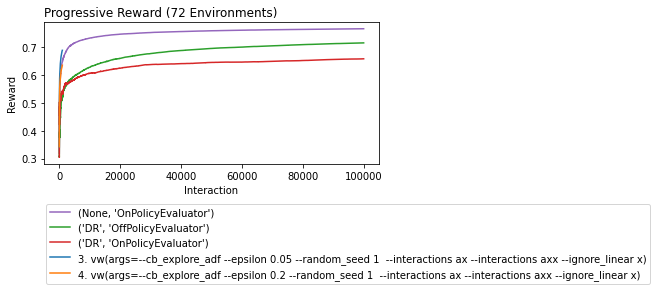

In [14]:
# Visualiziing the whole data

result2\
    .filter_val(eval_type={'!=':'ExplorationEvaluator'})\
    .plot_learners(l=['ope_reward','eval_type'],p='openml_task',colors=[2,3,4],out=None)

result2\
    .filter_val(eval_type={'=':'ExplorationEvaluator'})\
    .filter_fin(1000,['ope_reward','learner_id'],'openml_task')\
    .plot_learners(colors=0)